In [1]:
#ssh dupi@192.168.0.14
#ros2 launch minibot_bringup bringup_robot.launch.py
#ros2 launch minibot_navigation2 bringup_launch.py map:=`ros2 pkg prefix minibot_navigation2`/share/minibot_navigation2/maps/baby_real_map_cut.yaml
#rviz2 -d `ros2 pkg prefix minibot_navigation2`/share/minibot_navigation2/rviz/nav2_view.rviz

In [2]:
from nav2_simple_commander.robot_navigator import BasicNavigator
from geometry_msgs.msg import PoseWithCovarianceStamped
from geometry_msgs.msg import PoseStamped
from rclpy.duration import Duration
import yaml
import rclpy

rclpy.init()
nav = BasicNavigator()

In [3]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

# 지도 이미지 로드
pgm_img = cv2.imread('./baby_real_map_cut.pgm', cv2.IMREAD_GRAYSCALE)
# PNG로 저장
cv2.imwrite('./baby_real_map_cut.png', pgm_img)

True

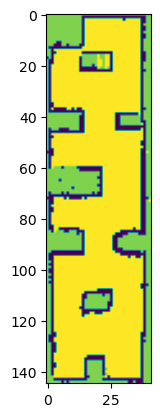

In [4]:
map_img = cv2.imread("./baby_real_map_cut.png",cv2.COLOR_BGR2GRAY )
plt.imshow(map_img)

In [5]:
def image_Grid(h, w, img):
    img_height, img_width = img.shape
    grid_size = (h, w)  # 세로, 가로
    
    # 그리드 영역 크기 계산
    cell_height = img_height // grid_size[0]
    cell_width = img_width // grid_size[1]

    
    map_cost = []
    map_col = []
    
    #각각의 그리드 영역에서 흰색 픽셀 비율 계산
    for i in range(grid_size[0]):
        map_col = []
        for j in range(grid_size[1]):
            # 그리드 영역의 범위를 지정하는거고
            cell_top = i * cell_height
            cell_left = j * cell_width
            cell_bottom = cell_top + cell_height
            cell_right = cell_left + cell_width
            
            
            if i == h-1:
                cell_bottom = img_height
                
            
            # 그 맵의 모든 픽셀을 가져와서
            cell = img[cell_top:cell_bottom, cell_left:cell_right]

            wall = 0
            load = 0
            for row in range(len(cell)):
                for col in range(len(cell[0])):
                
                    if cell[row][col] <= 210:
                        wall += 1;
                    else:
                        load += 1
            
                
            if load > wall:
                map_col.append(0)
            else:
                map_col.append(1)
        
        map_cost.append(map_col)
                
    return map_cost, cell_height, cell_width

In [6]:
my_map, cell_height, cell_width = image_Grid(12, 3, map_img)
for i in my_map:
    print(i)

[1, 0, 0]
[0, 1, 0]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[1, 1, 0]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0]
[0, 1, 0]


In [7]:
# YAML 파일 경로 
# 나중에 유저에게 맵 위치만 입력을 받게할 수 있을 
yaml_path = "./baby_real_map_cut.yaml"

# YAML 파일 읽기
with open(yaml_path, "r") as stream:
    yaml_data = yaml.safe_load(stream)

# resolution 값 가져오기
resolution = yaml_data["resolution"]

print(resolution)

0.05


In [8]:
class Astar:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

    def heuristic(self, node, goal, D=1, D2=2 ** 0.5):  # Diagonal Distance
        dx = abs(node.position[0] - goal.position[0])
        dy = abs(node.position[1] - goal.position[1])
        return D * (dx + dy)


    def aStar(self, maze, start, end):
        # startNode와 endNode 초기화
        startNode = Astar(None, start)
        endNode = Astar(None, end)

        # openList, closedList 초기화
        openList = []
        closedList = []

        # openList에 시작 노드 추가
        openList.append(startNode)

        # endNode를 찾을 때까지 실행
        while openList:

            # 현재 노드 지정
            currentNode = openList[0]
            currentIdx = 0

            # 이미 같은 노드가 openList에 있고, f 값이 더 크면
            # currentNode를 openList안에 있는 값으로 교체
            for index, item in enumerate(openList):
                if item.f < currentNode.f:
                    currentNode = item
                    currentIdx = index

            # openList에서 제거하고 closedList에 추가
            openList.pop(currentIdx)
            closedList.append(currentNode)

            # 현재 노드가 목적지면 current.position 추가하고
            # current의 부모로 이동
            if currentNode == endNode:
                path = []
                current = currentNode
                while current is not None:
                    # maze 길을 표시하려면 주석 해제
                    x, y = current.position
                    maze[x][y] = 2
                    path.append(current.position)
                    current = current.parent
                return path[::-1]  # reverse

            children = []
            # 인접한 xy좌표 전부
            for newPosition in [(0, -1), (0, 1), (-1, 0), (1, 0)]:

                # 노드 위치 업데이트
                nodePosition = (
                    currentNode.position[0] + newPosition[0],  # X
                    currentNode.position[1] + newPosition[1])  # Y
                    
                # 미로 maze index 범위 안에 있어야함
                within_range_criteria = [
                    nodePosition[0] > (len(maze) - 1),
                    nodePosition[0] < 0,
                    nodePosition[1] > (len(maze[len(maze) - 1]) - 1),
                    nodePosition[1] < 0,
                ]

                if any(within_range_criteria):  # 하나라도 true면 범위 밖임
                    continue

                # 장애물이 있으면 다른 위치 불러오기
                if maze[nodePosition[0]][nodePosition[1]] != 0:
                    continue

                new_node = Astar(currentNode, nodePosition)
                children.append(new_node)

            # 자식들 모두 loop
            for child in children:

                # 자식이 closedList에 있으면 continue
                if child in closedList:
                    continue

                # f, g, h값 업데이트
                child.g = currentNode.g + 1
                child.h = ((child.position[0] - endNode.position[0]) **
                        2) + ((child.position[1] - endNode.position[1]) ** 2)
                # child.h = heuristic(child, endNode) 다른 휴리스틱
                # print("position:", child.position) 거리 추정 값 보기
                # print("from child to goal:", child.h)
                
                child.f = child.g + child.h

                # 자식이 openList에 있으고, g값이 더 크면 continue
                if len([openNode for openNode in openList
                        if child == openNode and child.g > openNode.g]) > 0:
                    continue
                        
                openList.append(child)

    def run(self, maze, start, end):
        path = self.aStar(maze, start, end)
        return maze, path

In [9]:
#그리드 한 칸의 크기와 resolution의 곱이 결국 이동한 m값이 됩니다.
garo_m = resolution * cell_width
sero_m = resolution * cell_height

print(garo_m, sero_m)

0.65 0.6000000000000001


In [10]:
my_map_coordinate = []
my_map_layer = []

cor_x = -1.3  #0.65씩 더하세요
cor_y = 0.6  #0.6씩 빼세요.
    
for i in range(len(my_map)):
    cor_x = -1.3
    cor_y = cor_y - 0.6
    for j in range(len(my_map[0])):
        cor_x = cor_x + 0.65
        if my_map[i][j] == 1:
            my_map_layer.append(None)
        elif my_map[i][j] == 0:
            my_map_layer.append([cor_x, cor_y])

    my_map_coordinate.append(my_map_layer)
    my_map_layer = []
    
for i in my_map_coordinate:
    print(i)
    print()

[None, [0.0, 0.0], [0.65, 0.0]]

[[-0.65, -0.6], None, [0.65, -0.6]]

[[-0.65, -1.2], [0.0, -1.2], [0.65, -1.2]]

[None, [0.0, -1.7999999999999998], None]

[[-0.65, -2.4], [0.0, -2.4], [0.65, -2.4]]

[None, None, [0.65, -3.0]]

[[-0.65, -3.6], [0.0, -3.6], [0.65, -3.6]]

[None, [0.0, -4.2], None]

[[-0.65, -4.8], [0.0, -4.8], [0.65, -4.8]]

[[-0.65, -5.3999999999999995], None, [0.65, -5.3999999999999995]]

[[-0.65, -5.999999999999999], [0.0, -5.999999999999999], [0.65, -5.999999999999999]]

[[-0.65, -6.599999999999999], None, [0.65, -6.599999999999999]]



In [11]:
my_map_coordinate = []
my_map_layer = []

cor_x = -1.3  #0.65씩 더하세요
cor_y = 0.6  #0.6씩 빼세요.
    
for i in range(len(my_map)):
    cor_x = -1.3
    cor_y = cor_y - 0.6
    for j in range(len(my_map[0])):
        cor_x = cor_x + 0.65
        if my_map[i][j] == 1:
            my_map_layer.append(None)
        elif my_map[i][j] == 0:
            goal = PoseStamped()
            goal.header.frame_id = 'map'
            goal.header.stamp = nav.get_clock().now().to_msg()
            goal.pose.position.x = cor_x
            goal.pose.position.y = cor_y
            goal.pose.position.z = 0.006378173828125
            goal.pose.orientation.x = 0.0
            goal.pose.orientation.y = 0.0
            goal.pose.orientation.z = 0.0
            goal.pose.orientation.w = 1.0
            my_map_layer.append(goal)

    my_map_coordinate.append(my_map_layer)
    my_map_layer = []

In [12]:
print("맵입니다.")
for i in my_map:
    print(i)
print()

temp_map = my_map
make_route = Astar()
start = (0, 1)
end = (2,1 )
result, path = make_route.run(temp_map , start, end)

print("경로 생성 맵입니다. 숫자 2는 경로입니다.")
for i in result:
    print(i)


맵입니다.
[1, 0, 0]
[0, 1, 0]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[1, 1, 0]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0]
[0, 1, 0]

경로 생성 맵입니다. 숫자 2는 경로입니다.
[1, 2, 2]
[0, 1, 2]
[0, 2, 2]
[1, 0, 1]
[0, 0, 0]
[1, 1, 0]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0]
[0, 1, 0]


In [13]:
print(path)

[(0, 1), (0, 2), (1, 2), (2, 2), (2, 1)]


In [14]:
 def go_my_robot(my_map_coordinate, start, end):
    my_map, cell_height, cell_width = image_Grid(12, 3, map_img)

    make_route = Astar()
    result, path = make_route.run(my_map , start, end)

    print("경로 생성 맵입니다. 숫자 2는 경로입니다.")
    for i in result:
        print(i)
        
    if path == None:
        print("이동할 수 없는 지점으로 이동을 명령하고 있습니다.")
        return
    else:
        path_0 = path[0]
        path = path[1:]

    for route in path:
        print("명령을 이수합니다." + str(route) + "좌표로 이동합니다." )
        
        #북쪽
        if route[1] - path_0[1] == 1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = 1.0
        
        #남쪽
        elif route[1] - path_0[1] == -1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = -1.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = 0.0
        
        # 서쪽
        elif route[0] - path_0[0] == -1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = 0.7
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = 0.7
            
        # 동쪽
        elif route[0] - path_0[0] == 1:
            my_map_coordinate[route[0]][route[1]].pose.orientation.x = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.y = 0.0
            my_map_coordinate[route[0]][route[1]].pose.orientation.z = -0.7
            my_map_coordinate[route[0]][route[1]].pose.orientation.w = 0.7
        nav.goToPose(my_map_coordinate[route[0]][route[1]])

        i=0
        while not nav.isTaskComplete():
            i = i+1
            feedback = nav.getFeedback()
            if feedback and i % 5 == 0:
                print("Distance remaining : " + str(feedback.distance_remaining) + " m")
                if feedback.distance_remaining > 0.1:
                    pass
                else:
                    print("Distance remaining : " + str(feedback.distance_remaining) + " m")
                    nav.cancelTask()
                    print("명령을 이수했습니다.")


        print(str(route) + "좌표로 이동했습니다." )
        print()
        path_0 = route
        
                        #nav.cancelTask()
            
        #if Duration.from_msg(feedback.navigation_time) > Duration(seconds = 10.0):
            #nav.cancelTask()

In [15]:
nav.waitUntilNav2Active()

[INFO] [1678971033.163372424] [basic_navigator]: Nav2 is ready for use!


In [16]:
go_my_robot(my_map_coordinate, (0,1), (11, 2))

경로 생성 맵입니다. 숫자 2는 경로입니다.
[1, 2, 2]
[0, 1, 2]
[0, 2, 2]
[1, 2, 1]
[0, 2, 2]
[1, 1, 2]
[0, 2, 2]
[1, 2, 1]
[0, 2, 2]
[0, 1, 2]
[0, 0, 2]
[0, 1, 2]
명령을 이수합니다.(0, 2)좌표로 이동합니다.


[INFO] [1678971035.167734345] [basic_navigator]: Navigating to goal: 0.65 0.0...


Distance remaining : 0.6000000238418579 m
Distance remaining : 0.6000000238418579 m
Distance remaining : 0.550000011920929 m
Distance remaining : 0.4000000059604645 m
(0, 2)좌표로 이동했습니다.

명령을 이수합니다.(1, 2)좌표로 이동합니다.


[INFO] [1678971037.681170799] [basic_navigator]: Navigating to goal: 0.65 -0.6...


Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.5874246954917908 m
Distance remaining : 0.5037410855293274 m
Distance remaining : 0.4037269055843353 m
Distance remaining : 0.25 m
(1, 2)좌표로 이동했습니다.

명령을 이수합니다.(2, 2)좌표로 이동합니다.


[INFO] [1678971040.774103383] [basic_navigator]: Navigating to goal: 0.65 -1.2...


Distance remaining : 0.800000011920929 m
Distance remaining : 0.75 m
Distance remaining : 0.75 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.45000001788139343 m
Distance remaining : 0.3499999940395355 m
Distance remaining : 0.25 m
(2, 2)좌표로 이동했습니다.

명령을 이수합니다.(2, 1)좌표로 이동합니다.


[INFO] [1678971044.328592387] [basic_navigator]: Navigating to goal: 0.0 -1.2...


Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.30000001192092896 m
(2, 1)좌표로 이동했습니다.

명령을 이수합니다.(3, 1)좌표로 이동합니다.


[INFO] [1678971047.796296420] [basic_navigator]: Navigating to goal: 0.0 -1.7999999999999998...


Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.5121371150016785 m
Distance remaining : 0.4207106828689575 m
Distance remaining : 0.37071067094802856 m
Distance remaining : 0.25 m
Distance remaining : 0.20000000298023224 m
(3, 1)좌표로 이동했습니다.

명령을 이수합니다.(4, 1)좌표로 이동합니다.


[INFO] [1678971052.669227855] [basic_navigator]: Navigating to goal: 0.0 -2.4...


Distance remaining : 0.800000011920929 m
Distance remaining : 0.75 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.3499999940395355 m
(4, 1)좌표로 이동했습니다.

명령을 이수합니다.(4, 2)좌표로 이동합니다.


[INFO] [1678971056.076440763] [basic_navigator]: Navigating to goal: 0.65 -2.4...


Distance remaining : 0.7034343481063843 m
Distance remaining : 0.7034343481063843 m
Distance remaining : 0.7034343481063843 m
Distance remaining : 0.6121441125869751 m
Distance remaining : 0.5121171474456787 m
Distance remaining : 0.4000000059604645 m
Distance remaining : 0.25 m
Distance remaining : 0.22071067988872528 m
Distance remaining : 0.22071067988872528 m
Distance remaining : 0.22071067988872528 m
Distance remaining : 0.22071067988872528 m
(4, 2)좌표로 이동했습니다.

명령을 이수합니다.(5, 2)좌표로 이동합니다.


[INFO] [1678971062.028720181] [basic_navigator]: Navigating to goal: 0.65 -3.0...


Distance remaining : 0.6853148341178894 m
Distance remaining : 0.6350642442703247 m
Distance remaining : 0.6350642442703247 m
Distance remaining : 0.5621605515480042 m
Distance remaining : 0.46209216117858887 m
Distance remaining : 0.4207106828689575 m
(5, 2)좌표로 이동했습니다.

명령을 이수합니다.(6, 2)좌표로 이동합니다.


[INFO] [1678971065.433674803] [basic_navigator]: Navigating to goal: 0.65 -3.6...


Distance remaining : 0.8034698367118835 m
Distance remaining : 0.8034698367118835 m
Distance remaining : 0.8034698367118835 m
Distance remaining : 0.7534698247909546 m
Distance remaining : 0.7534698247909546 m
Distance remaining : 0.7534698247909546 m
Distance remaining : 0.5034703612327576 m
Distance remaining : 0.45346489548683167 m
Distance remaining : 0.4207106828689575 m
(6, 2)좌표로 이동했습니다.

명령을 이수합니다.(6, 1)좌표로 이동합니다.


[INFO] [1678971070.232200957] [basic_navigator]: Navigating to goal: 0.0 -3.6...


Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6378617286682129 m
Distance remaining : 0.6121761798858643 m
Distance remaining : 0.5621605515480042 m
Distance remaining : 0.5621605515480042 m
Distance remaining : 0.4707106947898865 m
Distance remaining : 0.4707106947898865 m
Distance remaining : 0.17071068286895752 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining 

[INFO] [1678971084.816756629] [basic_navigator]: Navigating to goal: 0.0 -4.2...


Distance remaining : 0.7222282886505127 m
Distance remaining : 0.7222282886505127 m
Distance remaining : 0.7222282886505127 m
Distance remaining : 0.7222282886505127 m
Distance remaining : 0.7222282886505127 m
Distance remaining : 0.45000001788139343 m
Distance remaining : 0.3499999940395355 m
(7, 1)좌표로 이동했습니다.

명령을 이수합니다.(8, 1)좌표로 이동합니다.


[INFO] [1678971088.799529220] [basic_navigator]: Navigating to goal: 0.0 -4.8...


Distance remaining : 0.800000011920929 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.699999988079071 m
Distance remaining : 0.6500000357627869 m
Distance remaining : 0.550000011920929 m
Distance remaining : 0.45000001788139343 m
Distance remaining : 0.4000000059604645 m
(8, 1)좌표로 이동했습니다.

명령을 이수합니다.(8, 2)좌표로 이동합니다.


[INFO] [1678971092.673858907] [basic_navigator]: Navigating to goal: 0.65 -4.8...


Distance remaining : 0.6853148341178894 m
Distance remaining : 0.6853148341178894 m
Distance remaining : 0.6853148341178894 m
Distance remaining : 0.6726038455963135 m
Distance remaining : 0.5724849104881287 m
Distance remaining : 0.4207106828689575 m
Distance remaining : 0.37071067094802856 m
(8, 2)좌표로 이동했습니다.

명령을 이수합니다.(9, 2)좌표로 이동합니다.


[INFO] [1678971096.318552014] [basic_navigator]: Navigating to goal: 0.65 -5.3999999999999995...


Distance remaining : 0.6375159025192261 m
Distance remaining : 0.6375159025192261 m
Distance remaining : 0.6375159025192261 m
Distance remaining : 0.6375159025192261 m
Distance remaining : 0.572654664516449 m
Distance remaining : 0.3914213478565216 m
Distance remaining : 0.2914213538169861 m
(9, 2)좌표로 이동했습니다.

명령을 이수합니다.(10, 2)좌표로 이동합니다.


[INFO] [1678971100.113895753] [basic_navigator]: Navigating to goal: 0.65 -5.999999999999999...


Distance remaining : 0.8034698367118835 m
Distance remaining : 0.7534698247909546 m
Distance remaining : 0.6037363409996033 m
Distance remaining : 0.6037363409996033 m
Distance remaining : 0.5537357926368713 m
Distance remaining : 0.4537311792373657 m
Distance remaining : 0.37071067094802856 m
(10, 2)좌표로 이동했습니다.

명령을 이수합니다.(11, 2)좌표로 이동합니다.


[INFO] [1678971104.144931516] [basic_navigator]: Navigating to goal: 0.65 -6.599999999999999...


Distance remaining : 0.7537357211112976 m
Distance remaining : 0.7537357211112976 m
Distance remaining : 0.7037356495857239 m
Distance remaining : 0.7037356495857239 m
Distance remaining : 0.5537351965904236 m
Distance remaining : 0.4207106828689575 m
Distance remaining : 0.37071067094802856 m
Distance remaining : 0.27071067690849304 m
Distance remaining : 0.27071067690849304 m
Distance remaining : 0.27071067690849304 m
Distance remaining : 0.27071067690849304 m
Distance remaining : 0.27071067690849304 m
Distance remaining : 0.22071067988872528 m
Distance remaining : 0.22071067988872528 m
(11, 2)좌표로 이동했습니다.



명령을 이수합니다.(1, 1)좌표로 이동합니다.


[INFO] [1678941971.843662073] [basic_navigator]: Navigating to goal: 1.1 0.0...


Distance remaining : 1.4021315574645996 m
Distance remaining : 1.4021315574645996 m
Distance remaining : 1.4021315574645996 m
Distance remaining : 1.4021315574645996 m
Distance remaining : 1.3314892053604126 m
Distance remaining : 1.190299153327942 m
Distance remaining : 1.0460014343261719 m
Distance remaining : 0.9862084984779358 m
Distance remaining : 0.8222092986106873 m
Distance remaining : 0.7033778429031372 m
Distance remaining : 0.5742974877357483 m
Distance remaining : 0.4568812847137451 m
Distance remaining : 0.3621320426464081 m
Distance remaining : 0.24142135679721832 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.19142135977745056 m
Distance remaining : 0.24142135679721832 m
Distance remaining : 0.24142135679721832 m
(1, 1)좌표로 이동했습니다.

명령을 이수합니다.(1, 2)좌표로 이동합니다.


[INFO] [1678941983.058964248] [basic_navigator]: Navigating to goal: 2.2 0.0...


Distance remaining : 0.8617819547653198 m
Distance remaining : 0.7117815017700195 m
Distance remaining : 0.6117828488349915 m
Distance remaining : 0.4617120623588562 m
Distance remaining : 0.3914213478565216 m
Distance remaining : 0.24142135679721832 m
(1, 2)좌표로 이동했습니다.

명령을 이수합니다.(0, 2)좌표로 이동합니다.


[INFO] [1678941986.171355237] [basic_navigator]: Navigating to goal: 2.2 1.1...


Distance remaining : 1.0830092430114746 m
Distance remaining : 1.0830092430114746 m
Distance remaining : 0.9611887335777283 m
Distance remaining : 0.8611887097358704 m
Distance remaining : 0.75 m
Distance remaining : 0.6500000357627869 m
Distance remaining : 0.5030601620674133 m
Distance remaining : 0.35297691822052 m
Distance remaining : 0.25 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
Distance remaining : 0.20000000298023224 m
(0, 2)좌표로 이동했습니다.

